# Tutorial for MUR SST on AWS  

- Funding: Interagency Implementation and Advanced Concepts Team [IMPACT](https://earthdata.nasa.gov/esds/impact) for the Earth Science Data Systems (ESDS) program and AWS Public Dataset Program

Credits: Tutorial development
* [Dr. Chelle Gentemann](mailto:gentemann@faralloninstitute.org)    - Farallon Institute, USA
* [Dr. Rich Signell](mailto:rsignell@usgs.gov) - USGS
* (parts this tutorial were adapted from the [pangeo](http://pangeo.io/) ocean_ssh_example.ipynb by [Dr. Ryan Abernathey](mailto:rpa@ldeo.columbia.edu))


Credits: Creating of the Zarr MUR SST dataset.  

* [Aimee Barciauskas](mailto:aimee@developmentseed.org) - Development Seed
* [Dr. Rich Signell](mailto:rsignell@usgs.gov) - USGS
* [Dr. Chelle Gentemann](mailto:gentemann@faralloninstitute.org)    - Farallon Institute, USA
* [Joseph Flasher](mailto:jflasher@amazon.com) - AWS
-------------


# Structure of this tutorial

1. Opening data
2. Data exploration
2. Data plotting

# 1. Opening data

-------------------

## Import python packages

It is nice to turn off warnings and set xarray display options

In [ ]:
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import fsspec

warnings.simplefilter('ignore') # filter some warning messages
xr.set_options(display_style="html")  #display dataset nicely 

### Start a cluster, the key to reading effectively on Cloud

- This will set up a cluster for you and give you a path that you can paste into the top of the Dask dashboard to visualize parts of your cluster.  
- You don't need to paste the link below into the Dask dashboard for this to work, only to see workers working.

In [ ]:
from dask_kubernetes import KubeCluster
from dask.distributed import Client

In [ ]:
cluster = KubeCluster(n_workers=40)
client = Client(cluster)
cluster

** ☝️ Don’t forget to click the link above or copy it to the Dask dashboard 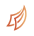 on the left to view the scheduler dashboard! **

### Initialize Dataset

Here we load the dataset from the zarr store. Note that this very large dataset initializes nearly instantly, and we can see the full list of variables and coordinates.

In [ ]:
%%time
file_location = 's3://mur-sst/zarr'
ds_sst = xr.open_zarr(fsspec.get_mapper(file_location, anon=True),consolidated=True)

### Examine Metadata

For those unfamiliar with this dataset, the variable metadata is very helpful for understanding what the variables actually represent
Printing the dataset will show you the dimensions, coordinates, and data variables with clickable icons at the end that show more metadata and size.

In [ ]:
ds_sst

# 2.  Explore the data

#### Let's explore the data

- With all data, it is important to explore it and understand what is contains before doing an analysis.
- The ice mask used by MUR SST is from NSIDC and is based on satellite passive microwave estimates of sea ice concentration
- The satellite data isn't available near land, so the is no estimate of sea ice concentration near land
- For this data, it means that there are some erroneous SSTs near land, that is likely ice and this is something to be aware of.

In [ ]:
sst = ds_sst['analysed_sst']

cond = (ds_sst.mask==1) & ((ds_sst.sea_ice_fraction<.15) | np.isnan(ds_sst.sea_ice_fraction))
sst_masked = ds_sst['analysed_sst'].where(cond)

### Using ``.groupby`` and ``.resample``
#### Create a monthly SST anomaly dataset
- First create a monthly version of the dataset using ``.resample``.  Two nice arguments for ``.resample``: ``keep_addrs`` which keeps the metadata and ``skipna`` which ensures that only data that is always present is included
- Calculate the monthly climatology using ``.groupby``
- Calculate the anomaly 


In [ ]:
%%time
sst_monthly = sst_masked.resample(time='1MS').mean('time',keep_attrs=True,skipna=False)

climatology_mean_monthly = sst_monthly.groupby('time.month').mean('time',keep_attrs=True,skipna=False)

sst_anomaly_monthly = sst_monthly.groupby('time.month')-climatology_mean_monthly  #take out annual mean to remove trends


In [ ]:
sst_anomaly_monthly

# 3. Data plotting

``xarray`` plotting functions rely on matplotlib internally, but they make use of all available metadata to make the plotting operations more intuitive and interpretable. More plotting examples are given [here](http://xarray.pydata.org/en/stable/plotting.html)

### Here we use ``holoviews`` and ``hvplot`` for interactive graphics

In [ ]:
import hvplot.xarray
import holoviews as hv
from holoviews.operation.datashader import regrid
hv.extension('bokeh')

### Plot the SST anomaly timeseries in the Pacific Blob Region


In [ ]:
%%time
monthly_timeseries_anomaly = sst_anomaly_monthly.sel(lon=-140, lat=53).drop('month')
#monthly_timeseries_anomaly = sst_anomaly_monthly.sel(lon=slice(-137.5,-132.5),lat=slice(45,50)).mean({'lat','lon'}).drop('month')

monthly_timeseries_anomaly.hvplot(grid=True)

### Load a global image of SST on 9/1/2016

In [ ]:
%%time
anom_save = sst_anomaly_monthly.sel(time='2016-09-01').load()

### Plotting on maps

For plotting on maps, we rely on the excellent [cartopy](http://scitools.org.uk/cartopy/docs/latest/index.html) library.

In [ ]:
import cartopy.crs as ccrs

### In cartopy you need to define the map projection you want to plot.  

- Common ones are Ortographic and PlateCarree.
- You can add coastlines and gridlines to the axes as well.

In [ ]:
anom_save.hvplot.quadmesh(x='lon', y='lat', geo=True, 
                         rasterize=True, clim=(-2,2), 
                         cmap='rainbow', 
                         projection=ccrs.Orthographic(-130, 35),
                         coastline='110m')

## A nice cartopy tutorial is [here](http://earthpy.org/tag/visualization.html)

# xarray can do more!

* concatentaion
* open network located files with openDAP
* import and export Pandas DataFrames
* .nc dump to 
* groupby_bins
* resampling and reduction

For more details, read this blog post: http://continuum.io/blog/xray-dask


## Where can I find more info?

### For more information about xarray

- Read the [online documentation](http://xarray.pydata.org/)
- Ask questions on [StackOverflow](http://stackoverflow.com/questions/tagged/python-xarray)
- View the source code and file bug reports on [GitHub](http://github.com/pydata/xarray/)

### For more doing data analysis with Python:

- Thomas Wiecki, [A modern guide to getting started with Data Science and Python](http://twiecki.github.io/blog/2014/11/18/python-for-data-science/)
- Wes McKinney, [Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do) (book)

### Packages building on xarray for the geophysical sciences


- [eofs](https://github.com/ajdawson/eofs): empirical orthogonal functions by Andrew Dawson
- [infinite-diff](https://github.com/spencerahill/infinite-diff) by Spencer Hill 
- [aospy](https://github.com/spencerahill/aospy) by Spencer Hill and Spencer Clark
- [regionmask](https://github.com/mathause/regionmask) by Mathias Hauser
- [salem](https://github.com/fmaussion/salem) by Fabien Maussion

Resources for teaching and learning xarray in geosciences:
- [Fabien's teaching repo](https://github.com/fmaussion/teaching): courses that combine teaching climatology and xarray
